In [1]:
import numpy
import torch
import torch.nn as nn
from collections import Counter


from IPython.display import Image
from IPython.core.display import HTML 

# Transformer Model

Transformer model是一种摒弃了循环及卷积结构，仅仅依赖于注意力机制的简洁的神经网络模型。我们知道recurrent network是一种sequential model，不能很好地解决长距离依赖的问题(序列过长时，信息在序列模型中传递时容易一点点丢失)，并且阻碍了parallelism within train example.而transformer 最引人瞩目的一点正是很好地解决了长距离依赖的问题，通过引入自注意力机制(self-attention)使得对依赖的建模与输入输出序列的距离无关，并且支持train exmaple内部的并行化

Transformer is consisited of 2 parts: 
- Encoder part (on the Left --> BERT)
- Decoder part (on the right --> GPT2, GPT3)

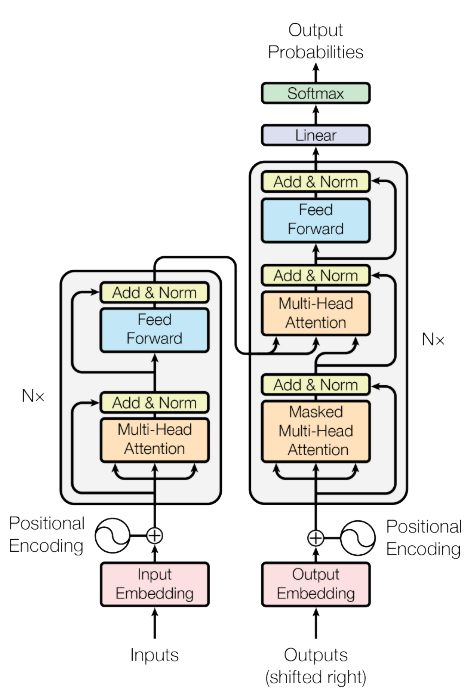

In [22]:
Image("https://brooksj.com/images/NLP/transformer_1.png")

</br>

Here's the Key Component for transformer Model (And we will implement them from scratch):
- Input Embedding Trick
- Positional Embedding
- Attension and self-attension Mechanism
- Add & Norm Block
- Feed Forward Block

So according to the graph (encoder on the left) above

- The first thing we need to do is that we have to embedding the text input data into input embedding and then ecoding them with positional encoding.
- After that we will pass the position encoded input embedding into multi-self attention block and sublayer ( with multi-head attention), and output will be out attention matrix
- The attention matrix will be feed into feedforward neural network
- and the result will be passed into next encoder block and we repeat the same process N times

# Input Embedding:

- Transform text data into numerical representations
- Embedding is just a lookup table and we will use one hot encoding to extract the vocab and it's coressponding Embedding vector
- These vectors will be updated as a paramter when model is being trained with gradient based optimization methods
- Use embedding is a common trick in NLP so that we can project high dimensional (1M dim) sparse text data (eg. one-hot encoding) into low dimensional dense numerical representation eg.50 dim 

In [26]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # vocab_size is the total number of word in your corpus 
        # embedding_dim is a hyperparameter (eg. 50, 100, 200, 300 are common choices)
        # we can also use d_model for embedding_dim
        torch.manual_seed(0)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        # x is the input
        return self.embedding(x)

And let's see an example how the embedding trasform the input text sentence

In [75]:
sentence = "I am good"
words = sentence.split(" ")
counts = Counter(words)

vocab_size = len(counts) # vocab_size is the total number of word in your corpus 
embedding_dim = 5 # embedding_dim is a hyperparameter (eg. 50, 100, 200, 300, 512 are common choices)
# 512 is the choice for transformer paper

sentence_embedding = Embedding(vocab_size, embedding_dim)

print(sentence_embedding.embedding.weight) # (3*5) => (word num * embedding_size)

Parameter containing:
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845],
        [-1.3986,  0.4033,  0.8380, -0.7193, -0.4033],
        [-0.5966,  0.1820, -0.8567,  1.1006, -1.0712]], requires_grad=True)


and for above 

- `I Embedding` ---> [ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845],

- `am Embedding` --->  [-1.3986,  0.4033,  0.8380, -0.7193, -0.4033]

- `good Embedding` ---> [-0.5966,  0.1820, -0.8567,  1.1006, -1.0712]

Notice that in linear algebra class, we see those 3 embedding vectors as column vector; but in tensorflow and pytorch, we treat them as row vector and stack them together (they are the same thing) but it might be confusing for beginners


- `I am good Embedding`: 

        [
            [ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845]
            [-1.3986,  0.4033,  0.8380, -0.7193, -0.4033]
            [-0.5966,  0.1820, -0.8567,  1.1006, -1.0712]
        ]

Notice that `I am good` is a `matrix X` and this is one batch of data sample (input embedding or input matrix)


# Positional Encodding

if you wanna know why they use sin and cosin for positional emcoding, check out two links down below

- https://kazemnejad.com/blog/transformer_architecture_positional_encoding/#the-intuition
- https://www.youtube.com/watch?v=dichIcUZfOw&ab_channel=Hedu-MathofIntelligence

In Recurrent Neural Network, we feed the sentence into model word by word (eg. `I am good` --> we will feed `I` into model, then use info of `I` and combine it with `am`). This cause some issues like long-term dependency issues, and gradient vanishing & exploding, and difficulty for parallel training

In transformer, we don't pass the sentence sequentially word by word. Instead, we feed the all the word parallally into the model so that we can reduce the trainning time and helps in long-dependency learning. But since we feed words parallelly, we need to encode position so that model is able to the capture the info of word order (notice that `Word Order` is a extremely crucial information in natural language task)

In order to add position information, we introduce a `matrix P`, the `P matrix` has the same dimension as the input matrix dimenssion. And we just simply do elementwise addtion on `P matrix` to `X input matrix`, and that's it :)

In [31]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False).cuda()
        return x

# Attention (Left) and Multi-Head Attention (Right) Mechanism

Now we move on to next block: attention block

In [5]:
Image(url = "https://brooksj.com/images/NLP/transformer_2.png")

## Query, Key, Value Matrix

We need Query, Key, Value Matrix to compose of the self-attention block.



And we can do `Q, K, V matrices` manually like below

Notice that we for here we will do dot prodict between query vector I and all the key vector, and we want dot product between Query I and Key I to be highest and then dot product between I and am , I and good to be next higest since we know am and good are related with I reather than How, are and you. ( We will do this for every query vector and it is esssentially the matrix maplication W_q * W_k T )

we divided by square root of d_model to gain a more stable gradient.

![Query, Key, Value](img/QKV.png)

In [ ]:
# get row vector and each word vector will have 3 q, k, v vectors
word_I = sentence_embedding.embedding.weight[0] # In transformer paper, dimension for it is 512 
word_I_q = torch.rand(word_I.shape) # In transformer paper, dimension for it is 64 not word_I.shape
word_I_k = torch.rand(word_I.shape)
word_I_v = torch.rand(word_I.shape)

# get row vector and each word vector will have 3 q, k, v vectors
word_am = sentence_embedding.embedding.weight[1]
word_am_q = torch.rand(word_am.shape)
word_am_k = torch.rand(word_am.shape)
word_am_v = torch.rand(word_am.shape)


# get row vector and each word vector will have 3 q, k, v vectors
word_good = sentence_embedding.embedding.weight[2]
word_good_q = torch.rand(word_good.shape)
word_good_k = torch.rand(word_good.shape)
word_good_v = torch.rand(word_good.shape)


# stack them back to input matrix embedding
input_matrix = torch.stack((word_I, word_am, word_good), dim = 0)

# get Query Matrix of input
W_query_matrix = torch.stack((word_I_q, word_am_q, word_good_q), dim = 0)

# get Key Matrix of input
W_key_matrix = torch.stack((word_I_k, word_am_k, word_good_k), dim = 0)

# get Value Matrix of input
W_value_matrix = torch.stack((word_I_v, word_am_v, word_good_v), dim = 0)

# Why Need Q, V, and K

Like the graph below, the intuition is that We compare the ‘query’ with the ‘keys’ and get scores/weights for the ‘values.’ Each score/weight is in short the relevance between the ‘query’ and each ‘key’. And you reweight the ‘values’ with the scores/weights, and take the summation of the reweighte‘values’.” 


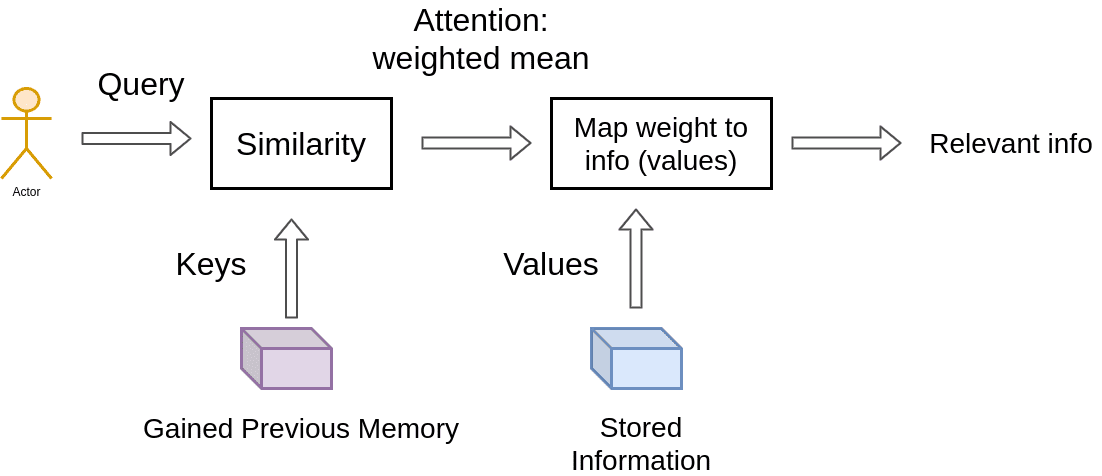

In [3]:
Image("https://theaisummer.com/static/2e000851b686eb35c6c3c06522437715/26a94/attention-as-database-query.png")

From the input matrix X, we create 3 matrices: Query Matrix, Key Matrix, and Value Matrix. And these 3 matrics are randomly initialized (similar with input embeddning) and their optimal values will be learnt during the training process.


> - `Query` - asking for information;
> - `Key` - saying that it has some information;
> - `Value` - giving the information.

The query is used when a token looks at others - it's seeking the information to understand itself better. The key is responding to a query's request: it is used to compute attention weights. The value is used to compute attention output: it gives information to the tokens which "say" they need it (i.e. assigned large weights to this token).





For recapping in order to get Query, Key and Value Matrix,:

- Plot on the right could be misleading rather than get Q, K and V and then linear transforming them, what it means is that we can do 3 different Linear transformation on the same input embedding to get Q, K and V and then feed them into scaled dot product attention block. here's the pesudo code and graph.


```
------------------------------------------------------------------------------------------------

def forward(self, input_embedding):

    # https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/fec78a687210851f055f792d45300d27cc60ae41/transformer/Layers.py
    
    enc_output, enc_slf_attn = self.self_attentiom(
        input_embedding, input_embedding, input_embedding
    )
    return enc_output, enc_slf_attn

def self_attention(q, k , v):
    q_linear, k_linear, v_linear =  nn.Linear(), nn.Linear(), nn.Linear()
    
    Q = q_linear(q)
    K = q_linear(k)
    V = q_linear(v)
    
    pass
    
------------------------------------------------------------------------------------------------
```

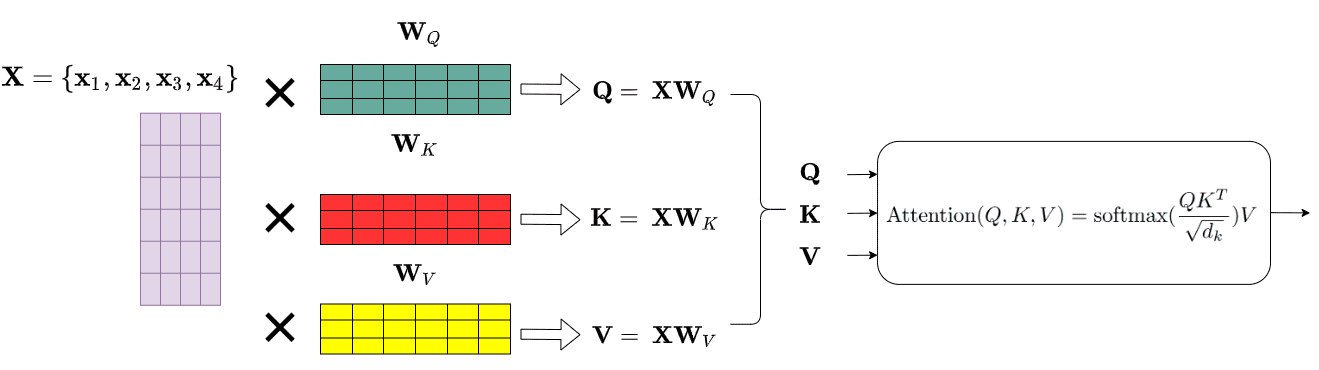

In [4]:
Image("https://theaisummer.com/static/56773616d30b9dcb31aa792f2d701276/3096d/key-query-value.png", height = 10, width = 10)

# Scaled Dot Product Attention


![attention block](img/scaled_dot_product1.png)

0. Linear Transform Q, K and V embedding
1. The Q Matrix * Key Matrix^T
2. Scale the step 1 result by divide square root of d_k
3. (Optional) Put mask on the results
4. Pass the result with softmax function
5. Multiply results with value matrix ( reweighting the value matrix)


For recapping in order to get Query, Key and Value Matrix,:

- (Right plot) shows that we can do 3 different Linear transformation on the same input embedding to get Q, K and V and then feed them into scaled dot product attention block.

- (Left plot) shows after getting get Q, K and V matrics we can do extra 3 linear transformation before feed into scaled dot-product (you don't need to do in this way)


In [79]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    # scaled dot product
    # since in deep learning we have (batch_size, vocab_size, embedding_size)
    # when do transpose we need to transpose second and third dimension: k.transpose(-2, -1))
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

# Multi-Head Attention

Multi-Head Attention could be a bit hard, and let's continue the example: `I am good How are you`

In this example, the `number of token` is `6` and each token is encoded as `512` dimension embedding vector (like what we discussed before) and the sentence `I am good How are you` is a 6 * 512 matrix. And the let's say the `number of head` is `8`, and we will split the embedding into 8 parts so 512 / 8 = 64

So each block will be dim = (6 * 64) and in deep learning we can put add one more dimension called head, and when concantate those heads simply by just removing that head dimension so that we can train the mulit-head attention parallelly.

![title](img/multihead_attention.png)

In [71]:
Image(url = "https://brooksj.com/images/NLP/transformer_2.png")

Multi-Head Attention could be a bit hard, and let's continue the example: `I am good How are you`

In this example, the `number of token` is `6` and each token is encoded as `512` dimension embedding vector (like what we discussed before) and the sentence `I am good How are you` is a 6 * 512 matrix. And the let's say the `number of head` is `8`, and we will split the embedding into 8 parts so 512 / 8 = 64

And here is the implementation in pytorch module

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        # Linear Transformation
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model) # final linear layer
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # Before h head split we have (batch_size, sent_len, d_model)
        # after h head split we have (batch_size, sent_len, h * d_k)
        # perform linear operation and split into h heads : h * d_k = d_model <==> 8 * 64 = 512 ( we expand the last dim)
        #                                    |
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions batch_size * head * split * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout) # scaled dot product
        
        # concatenate heads and put it through final linear layer
        # we can put add one more dimension called head using view 
        # and when concantate simply just remove that head dimension 
        # so that we can train the mulit-head attention parallelly
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model) # concatenation block
        
        output = self.out(concat) # Linear block
    
        return output

## Another 2 kinds of Attention

For attention implementation, we notice that there exists parameters called mask


The transformer acutally contains three kinds attention. And they are inherently same wihth little differences

1. Encoder self attention (multi-head) in encoder: what we have already implemented above. (Red)
2. Decoder self attention in decoder: Masked multi-head Attention (Green)
3. Encoder-decoder (cross) attention, which is similar to the concept of attention model. **It uses Attention matrix from encoder to generate Query matrix and use attention matrix from decoder to gain Key and Value matrix.** (Blue)


![example](img/three_attention_block.png)

# Decoder Attention (masked)

In [4]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    # transpose 1 and 2 from (batch, vocab_size, embedding_size) to (batch, embedding_size, vocab_size)
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    
    # adding mask (we add attention mask after computing the scaled dot product)
    if mask is not None:
        # a = torch.tensor([1, 0, 2, 3,])    T  F  F  F
        # a.masked_fill(mask = torch.tensor([1, 0, 0, 0]), value = -1000) => torch.tensor([-1000, 0, 2, 3,])
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9) # fill the scores with -1e9 when element in mask == 0

    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

# Encoder & Decoder Attention

> - `Query` - asking for information from `decoder`;
> - `Key` - saying that it has some information in the `encoder` Think it as a library;
> - `Value` - giving the information revelant with enocder key.

# Add & Norm Block


Another important component in the transformers model is the Add & Norm block. It connects the input and output of the sublayers. As we can see above, the add & norm block connects the output of multi-head attention and the feed forward block. 

The self-attention matrix will be added onto position encoded embedding and then we add layer nomralization on the matrix
![example](img/add_norm.png)


The add and norm component is basically a `residual connection` followed by `layer normalization.` 

- A residual connection is basically just taking the input and adding it to the output of the sub-network, making training deep networks easier in the field of computer vision. (Helpful for fighting gradient vanishing)
- Layer normalization is a normalization method in deep learning that is similar to batch normalization. In layer normalization, the statistics are computed across each feature and are independent of other examples batch. The independence between inputs means that each input has a different normalization operation.



The Layer normalization will helps faster training and faster convergence to optimal point by preventing the values in the each layer change heavily (parameter updating in neural netwok prefers small graudal change rather dramatic change). And Layer normalization is frequently used in NLP and Batch normalization is more pouplar in computer vision

> There has also been work on alternative normalization
techniques, and in particular Layer Normalization (LN),
proposed by [1]. LN normalizes across the channel/feature
dimension as shown in Figure 1. This could be extended
to Group Norm (GN) [41], where the normalization is
performed across a partition of the features/channels
with different pre-defined groups. Instance Normalization (IN) [36] is another technique, where p


![example](img/layer_normalize1.png)

# Feedforward Block

The feedforawrd network consists of two dense layers with ReLU activations. The parameters of the feedforward network are the same over the different positions of the sentence and different over the encoder blocks

In [2]:
class FeedForawrd(nn.Module):

    def __init__(self, d_model, dropout = 0.1):
        super().__init__()
        self.Linear1 = nn.Linear(d_model, d_model)
        self.Linear2 = nn.Linear(d_model, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(input) # layer normalization
       
    def forward(self, x):
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        
        x += residual # resdiual connection
        x = self.layer_norm(x)
        return x

# Reference Resource:
- https://jalammar.github.io/illustrated-transformer/
- https://bgg.medium.com/seq2seq-pay-attention-to-self-attention-part-2-cf81bf32c73d
- https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1
- https://data-science-blog.com/blog/2021/04/07/multi-head-attention-mechanism/
- https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec
- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
- https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/fec78a687210851f055f792d45300d27cc60ae41/transformer/SubLayers.py#L9
- https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
- batchnormalization: https://arxiv.org/pdf/2003.07845v1.pdf
- https://theaisummer.com/normalization/